In [150]:
%matplotlib inline
import cv2
from numpy import floor
from scipy.ndimage.filters import gaussian_filter1d
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.interpolation import map_coordinates
from scipy.spatial.distance import cdist
import math
import matplotlib.pyplot as plt
import numpy as np



In [151]:
def normalize(img):
    '''
     Function to normalize an input array to 0-1 
    '''
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min)

def my_normalize(matches):
    mean_num = np.mean(matches,axis=0)
    m_off = np.eye(3,dtype=float)
    m_off[0][2],m_off[1][2] = -mean_num[0],-mean_num[1]
    m_scale= np.eye(3,dtype=float)
    m_scale[0, 0] = 1.0 / max(abs(matches[:, 0]))
    m_scale[1, 1] = 1.0 / max(abs(matches[:, 1]))
    coor_trans = np.matmul(m_scale,m_off)
    noralized_match = np.transpose(np.matmul(coor_trans,
                                             np.transpose(matches)))
    
    return coor_trans,noralized_match


In [152]:
"""
Function for harris edge detections
"""
edge = 16
def harris(img, num_of_points =500):    
    direction_x = gaussian_filter1d(
        gaussian_filter1d(img.astype(np.float32), 1.0, 0, 0), 1.0, 1, 1
    )
    direction_y = gaussian_filter1d(gaussian_filter1d(img.astype(np.float32),
            1.0, 1, 0), 1.0, 0, 1)
    h = (gaussian_filter(direction_x ** 2, 1.5, 0) * gaussian_filter(direction_y ** 2, 1.5, 0) - gaussian_filter(direction_x * direction_y, 1.5, 0)**2) \
        / (gaussian_filter(direction_x**2, 1.5, 0) + gaussian_filter(direction_y**2, 1.5, 0) + 1e-8)
    h[:edge, :], h[-edge:, :], h[:, :edge], h[:, -edge:] = 0, 0, 0, 0
    mask = h == maximum_filter(h,(8,8))
    h = h * mask
    final_pairs = np.argsort(h.flatten())[::-1][:num_of_points ]
    return np.vstack((final_pairs % img.shape[0:2][1], final_pairs / img.shape[0:2][1], h.flatten()[final_pairs])).transpose()


In [153]:
neighbor_hood=8 # neighbor numbers
def extract_decriptor(img, harris ):
    """
    Function to extract descriptor 
    :param img:  input image
    :param harris: harris cornor 
    :return: descriptor from detected points
    """
    # Change number here to change the scale. 4 is the optimal amount 
    y, x = 4 * np.mgrid[-neighbor_hood:neighbor_hood+1, -neighbor_hood:neighbor_hood+1]
    descriptor = np.zeros((2 * neighbor_hood + 1, 2 * neighbor_hood + 1, harris.shape[0]), dtype=float)
    for i in range(harris.shape[0]):
        tmp_points = map_coordinates(img,[harris[i,1] + y, harris[i,0] + x], prefilter=False)
        # normalize the descriptor
        descriptor[..., i] = (tmp_points - tmp_points.mean()) / tmp_points.std()
    return descriptor

In [154]:

def get_match_from_dist(d1, d2,threshold = 0.7):
    """
        Function to get matches from descriptor according to cdist
    """
    _, width, n = d1.shape[0:3]
    distance = cdist((d1.reshape((width**2, n))).T, (d2.reshape((width**2, n))).T)
    best_current = np.argsort(distance, 1)[:, 0]
    # calculate the ration compared to best matches
    ratio = distance[np.r_[0:n], best_current] / distance[np.r_[0:n], np.argsort(distance, 1)[:, 1]].mean()
    return np.hstack([np.argwhere(ratio < threshold), best_current[np.argwhere(ratio < threshold)]]).astype(int)



In [155]:
def homo_coor(points_list):
    """
    :param points_list: 3*N points list
    :return: homogeneous coordinates
    """
    # if 3*N
    if points_list.shape[0] == 3:
        homo_coordinates = np.zeros_like(points_list)
        for i in range(3):
            # divide the last row
            homo_coordinates[i, :] = points_list[i, :] / points_list[2, :]
    # if 2*N, append np.ones and return 
    elif points_list.shape[0] == 2: 
        homo_coordinates = np.vstack((points_list, 
                         np.ones((1, points_list.shape[1]),dtype=points_list.dtype)))
    return homo_coordinates


In [156]:


def cal_homo_Matrix(point1, point2):
    """
    get homography based on two points
    :param point1: point1
    :param point2: point2
    :return: homograph of an image
    """
    A = np.matrix(np.zeros((point1.shape[0]*2, 8), dtype=float), dtype=float)
    for i in range(0, A.shape[0]):
        if i % 2 == 0:
            A[i,0] = point1[i//2,0]
            A[i,1] = point1[i//2,1]
            A[i,2] = 1
            A[i,6] = -point2[i//2,0] * point1[i//2,0]
            A[i,7] = -point2[i//2,0] * point1[i//2,1]
        else:
            A[i,3] = point1[i//2,0]
            A[i,4] = point1[i//2,1]
            A[i,5] = 1
            A[i,6] = -point2[i//2,1] * point1[i//2,0]
            A[i,7] = -point2[i//2,1] * point1[i//2,1]
    
    # get flattened b
    b = point2.flatten().reshape(point2.flatten().shape[1], 1).astype(float)
    
    # Calculating  A * x = b
    x = np.array(np.linalg.lstsq(A,b)[0])
    
    x = np.append(x,np.matrix(1)).reshape((3,3))
    return x
   

In [157]:

def cal_cornor(homography, img_path):
    """
    get cornors according to homograph
    :param homography: 
    :param img_path: 
    :return: 
    """
    mid_point = None
    List_C = []
    for i in range(len(img_path)):
        height, width = cv2.imread(img_path[i]).shape[0:2]
        List_C.append(homo_coor(np.dot(homography[i], 
                                    homo_coor(np.array([[0, width, width, 0], [0, 0, height, height]], dtype=float)))).astype(int))
        # if i is half, then midpoint is last of C
        if i == len(img_path)/2:
            mid_point = List_C[-1]
    w_list1 = []
    w_list2 = []
    h_list1 = []
    h_list2 = []
    for i in range(len(List_C)):
        w_list1 += [np.min(List_C[i][0, :])]
        h_list1 += [np.min(List_C[i][1, :])]
        h_list2 += [np.max(List_C[i][1, :])]
        w_list2 += [np.max(List_C[i][0, :])]
    result = np.array([(min(w_list1), min(h_list1)), (max(w_list2), max(h_list2))]), mid_point
    return result

In [158]:
def cal_middle_homo(homo_Matrix,img_size):
    """
    :param homo: 
    :return: 
    """
    middle_Homo = []
    # cal middle one's homo matrix 
    homo_Matrix[1] = homo_Matrix[0] * homo_Matrix[1]
    for i in range(len(homo_Matrix)):
        middle_Homo.append(np.linalg.inv(homo_Matrix[img_size//2]) * homo_Matrix[i])
    return middle_Homo

In [159]:

 # def plot_plane(a, b, c, d):
 #        xx, yy = np.mgrid[:10, :10]
 #        return xx, yy, (-d - a * xx - b * yy) / c
 # 
 #    n = 100
 #    max_iterations = 100
 #    goal_inliers = n * 0.3


def ransac(Matches, tolerance=0.5, iteration=100):
    """
    
    :param Matches: matches selected
    :param tolerance: tolerance for model 
    :param iteration: max iteration number
    :return: homo_matrix
    """
    # counter for iteration cnt
    count = 0
    # record last best model info
    last_consensus_cnt = 0
    last_homo,last_count = None, None
    print("Matches shape",Matches.shape)
    
    while count < iteration:
        sample_points = np.copy(Matches)
        tmp_Matches = np.matrix(np.copy(Matches))
       
        #      try ransac for inliers
        # m, b = run_ransac(xyzs, estimate, lambda x, y: is_inlier(x, y, 0.01), 3, goal_inliers, max_iterations)
        # a, b, c, d = m
        # xx, yy, zz = plot_plane(a, b, c, d)
        # ax.plot_surface(xx, yy, zz, color=(0, 1, 0, 0.5))

        # Gets a random set of points on RANSAC
        np.random.shuffle(sample_points)

        # get 4 sample points
        sample_points = np.matrix(sample_points)[0:4]
        # get homo matrix based on this two points
        homo_matrix = cal_homo_Matrix(sample_points[:,0:2], sample_points[:,2:4])
        residual_tmp = np.power(np.array(np.array(homo_coor((homo_matrix * homo_coor(tmp_Matches[:,0:2].transpose())))[0:2,:]) 
                                  - tmp_Matches[:,2:].transpose()),2)
        # cal the residual of this model
        residual = np.sqrt(residual_tmp.sum(0))
        less_than_tol_cnt = (residual < tolerance).sum()
        # if new model is better than model before
        
            #      best_ic = 0
            # best_model = None
            # random.seed(random_seed)
            # # random.sample cannot deal with "data" being a numpy array
            # data = list(data)
        
        if last_consensus_cnt < less_than_tol_cnt  :
            # update homo
            last_homo = homo_matrix
            last_consensus_cnt = (residual < tolerance).sum()
            last_count = np.argwhere(residual < tolerance)
            
            Matrix_P = float(last_consensus_cnt) / Matches.shape[0]
           
            # update iteration number according to Matrix P
            itertation = math.log(0.05) * (1/math.log(1-(np.power(Matrix_P,4))))
            
        count += 1
    return last_homo


In [160]:
def image_transformation(image, middle, Cornors):
    """
     transorm image based on homography
    :param im: image 
    :param t: middle points
    :param o: Cornor
    :return: 
    """
    tmp_y, tmp_x = np.mgrid[Cornors[0, 1]:Cornors[1, 1],
                   Cornors[0, 0]:Cornors[1, 0]]
    
    height = Cornors[1, 1] - Cornors[0, 1]
    width = Cornors[1, 0] - Cornors[0, 0] 
    A = homogeneous(np.dot(np.linalg.inv(middle), homogeneous(np.vstack((tmp_x.flatten(), tmp_y.flatten())))))
    x_a = A[0,:].reshape((height, width))
    y_a = A[1,:].reshape((height, width))
    
    result = np.zeros((height, width, image.shape[2]), dtype=image.dtype)
    if image.ndim == 3:
        for dimension in range(image.shape[2]):
            #need broadcast here
            result[..., dimension] = map_coordinates(image[..., dimension], [y_a, x_a])
    else:
        result = map_coordinates(image, [y_a, x_a])
    return result


In [161]:
def image_blending(img_path, middle_homo):
    """
    :param img_path: all images
    :param middle_homo: middle homo 
    :return: blending result
    """
    tmp_image_list = []
    # blend sigma higher, then incoming image more vague
    blend_sigma = float(10)
    # need to read again because we need color image
    for i in range(len(img_path)):
        im = cv2.imread(img_path[i])
        y_size, x_size = np.mgrid[0:im.shape[0], 0:im.shape[1]]
        im = np.dstack((im, np.exp(-((y_size - im.shape[0]/2) ** 2 + (x_size - im.shape[1]/2) ** 2) / (2.0 * blend_sigma ** 2)))) 
        tmp_image_list.append(image_transformation(im, np.array(middle_Homo[i]), cal_cornor(middle_Homo, img_path)[0]))
        
    # Combining all of the img
    Matrix1 = np.zeros(tmp_image_list[0].shape, dtype=float)
    Matrix2 = np.zeros(tmp_image_list[0].shape, dtype=float)
    Matrix2[:,:,3] = np.float(1.0)
    for i in range(len(tmp_image_list)):
        Matrix1[:,:,0] = Matrix1[:,:,0] + tmp_image_list[i][:,:,3] * tmp_image_list[i][:,:,0]
        Matrix1[:,:,1] = Matrix1[:,:,1] + tmp_image_list[i][:,:,3] * tmp_image_list[i][:,:,1]
        Matrix1[:,:,2] = Matrix1[:,:,2] + tmp_image_list[i][:,:,3] * tmp_image_list[i][:,:,2]
        Matrix1[:,:,3] = Matrix1[:,:,3] + tmp_image_list[i][:,:,3]
        
        Matrix2[:,:,0] =  Matrix2[:,:,0] + tmp_image_list[i][:,:,3]
        Matrix2[:,:,1] = Matrix2[:,:,1] + tmp_image_list[i][:,:,3]
        Matrix2[:,:,2] = Matrix2[:,:,2] + tmp_image_list[i][:,:,3]
        
    Matrix2[Matrix2 == 0] = 1
    return Matrix1/Matrix2

In [162]:
# img_1_left_path = "data\\part1\\Image1.jpg"
# img_1_right_path = "data\\part1\\Image2.jpg"
img_1_left_path = "data\\part1\\left.jpg"
img_1_right_path = "data\\part1\\right.jpg"

# hill
hill_left_path = "data\\part1\\hill\\1.jpg"
hill_mid_path = "data\\part1\\hill\\2.jpg"
hill_left_mid_path = "data\\part1\\hill\\image_processed.jpg"

hill_right_path ="data\\part1\\hill\\3.jpg"


# output folder path
out_path = "data\\part1\\output\\"




In [143]:
#workable for sample image left and right
# 0.7 and 0.8 very good

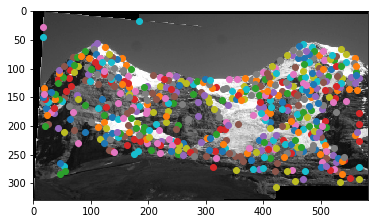

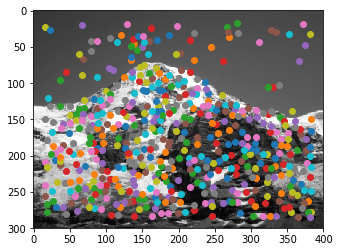

num of initial_matches: 196
Matches shape (196, 4)


C:\Users\bluerain\PycharmProjects\cvmp2\new_venv\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [144]:
# path of all images
img_path = [hill_left_mid_path,hill_right_path]
homo_Matrix = [np.matrix(np.identity(3))]

for i in range(len(img_path) - 1):
    # read gray scale image first 
    img1 = cv2.imread(img_path[i],0)
    img2 = cv2.imread(img_path[i+1],0)
    # harris cornor detector
    harris_points2 = harris(img2, num_of_points=500)
    harris_points1 = harris(img1, num_of_points=500)

    # display feature points of first image
    plt.imshow(img1,cmap='gray')
    for points in harris_points1:
        plt.scatter(points[0], points[1])
        plt.draw()
    plt.show()
    
    # display feature points of second image
    plt.imshow(img2,cmap='gray')
    for points in harris_points2:
        plt.scatter(points[0], points[1])
        plt.draw()
    plt.show()
    
    # extract neighbors as descriptors
    descriptor_1 = extract_decriptor(img1, harris_points1)
    descriptor_2 = extract_decriptor(img2, harris_points2)
    
    # we can adjust the threshold to have more or less matches
    initial_matches = get_match_from_dist(descriptor_1, 
                       descriptor_2,
                       threshold=0.6)
    
    print("num of initial_matches:", len(initial_matches))
    
    # we can adjust the tolerance for better model
    selected_points = np.matrix(np.hstack((harris_points1[initial_matches[:,0],0:2], harris_points2[initial_matches[:,1],0:2])))
    h = ransac(selected_points, tolerance=0.5, iteration=300)
    homo_Matrix.append(np.linalg.inv(h))



panorama image:


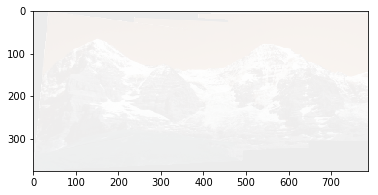

True

In [163]:
middle_Homo = cal_middle_homo(homo_Matrix,len(img_path))

result_img = image_blending(img_path, middle_Homo)

print("panorama image:")
plt.imshow(normalize(result_img))
# normalize(result_img),cmap='')
plt.show()
cv2.imwrite(out_path+"stitched_image.jpg", result_img)

